In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
fp_2023 = "MMSA2023.xpt"
fp_2020 = "MMSA2020.xpt"
fp_2019 = "MMSA2019.xpt"
fp_2015 = "MMSA2015.xpt"

In [3]:
df_2023 = pd.read_sas(fp_2023, format="xport")
df_2020 = pd.read_sas(fp_2020, format="xport")
df_2019 = pd.read_sas(fp_2019, format="xport")
df_2015 = pd.read_sas(fp_2015, format="xport")

In [42]:
df_2015['MENTHLTH']

0         88.0
1         88.0
2         88.0
3         88.0
4          1.0
          ... 
229010    20.0
229011    15.0
229012    88.0
229013    88.0
229014    88.0
Name: MENTHLTH, Length: 229015, dtype: float64

In [4]:
# for df in [df_2015, df_2019, df_2020, df_2023]:
#     df.dropna(subset=['MENTHLTH'], inplace=True)

In [40]:
df_2015['MMSANAME']

0             Aberdeen, SD, Micropolitan Statistical Area
1             Aberdeen, SD, Micropolitan Statistical Area
2             Aberdeen, SD, Micropolitan Statistical Area
3             Aberdeen, SD, Micropolitan Statistical Area
4             Aberdeen, SD, Micropolitan Statistical Area
                               ...                       
229010    Worcester, MA-CT, Metropolitan Statistical Area
229011    Worcester, MA-CT, Metropolitan Statistical Area
229012    Worcester, MA-CT, Metropolitan Statistical Area
229013    Worcester, MA-CT, Metropolitan Statistical Area
229014    Worcester, MA-CT, Metropolitan Statistical Area
Name: MMSANAME, Length: 229015, dtype: object

In [41]:
print(df_2015["MMSANAME"].unique()[:10])

['Aberdeen, SD, Micropolitan Statistical Area'
 'Akron, OH, Metropolitan Statistical Area'
 'Albany-Schenectady-Troy, NY, Metropolitan Statistical Area'
 'Albuquerque, NM, Metropolitan Statistical Area'
 'Allentown-Bethlehem-Easton, PA-NJ, Metropolitan Statistical Area'
 'Anchorage, AK, Metropolitan Statistical Area'
 'Atlanta-Sandy Springs-Roswell, GA, Metropolitan Statistical Area'
 'Augusta-Richmond County, GA-SC, Metropolitan Statistical Area'
 'Austin-Round Rock, TX, Metropolitan Statistical Area'
 'Baltimore-Columbia-Towson, MD, Metropolitan Statistical Area']


In [6]:
def extract_city_state_menthlth(df):
    
    if isinstance(df["MMSANAME"].iloc[0], bytes):
        df["MMSANAME"] = df["MMSANAME"].str.decode("latin-1")

    extracted = df["MMSANAME"].str.extract(
        r"^([^,]+),\s*([A-Z\-]+),\s*(?:Metropolitan|Micropolitan)",
        expand=True
    )
    extracted.columns = ["CITY", "STATE_ABBR"]

    df_clean = pd.DataFrame({
        "MENTHLTH": pd.to_numeric(df["MENTHLTH"], errors="coerce"),
        "CITY": extracted["CITY"],
        "STATE_ABBR": extracted["STATE_ABBR"]
    })

    df_clean = df_clean.dropna(subset=["MENTHLTH", "CITY", "STATE_ABBR"])

    df_clean["STATE_ABBR"] = df_clean["STATE_ABBR"].astype(str)
    df_clean["STATE_ABBR"] = df_clean["STATE_ABBR"].str.split("-")
    df_clean = df_clean.explode("STATE_ABBR").reset_index(drop=True)

    state_mental_health = (
        df_clean.groupby("STATE_ABBR")["MENTHLTH"]
        .mean()
        .reset_index()
        .rename(columns={"MENTHLTH": "AVG_MENTHLTH"})
    )

    return state_mental_health

In [46]:
df_clean_2019 = extract_city_state_menthlth(df_2019)
df_clean_2023 = extract_city_state_menthlth(df_2023)
# df_clean_2015

In [47]:
# work on whats gentriftied, figure out that county!
#find something that's gentrifired
# fishtown, phily, 
# do county level, neighbourhodod level


In [48]:
us_state_abbrev = {
    'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA',
    'Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','District of Columbia': 'DC',
    'Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL',
    'Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA',
    'Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN',
    'Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV',
    'New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY',
    'North Carolina': 'NC','North Dakota': 'ND','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR',
    'Pennsylvania': 'PA','Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD',
    'Tennessee': 'TN','Texas': 'TX','Utah': 'UT','Vermont': 'VT','Virginia': 'VA',
    'Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY'
}

In [49]:
usa_shp = gpd.read_file('National_Obesity_By_State-shp/National_Obesity_By_State.shp')
usa_shp["STATE_ABBR"] = usa_shp["NAME"].map(us_state_abbrev)

In [50]:
# usa_shp.plot()

In [51]:
merged_data_2015 = usa_shp.merge(df_clean_2019,on = 'STATE_ABBR',how='left')
merged_data_2023 = usa_shp.merge(df_clean_2023,on = 'STATE_ABBR',how='left')

In [52]:
# fig, ax = plt.subplots(1, figsize=(6,10))
# merged_data_2023.plot(
#     ax=ax,
#     column='AVG_MENTHLTH',
#     legend=True,
#     cmap='RdYlGn',
#     edgecolor='grey',
#     linewidth=0.5,
#     legend_kwds={
#         "fmt": "{:,.0f}",
#         "orientation": "vertical",
#         "shrink": 0.5,
#         "pad": 0.01,
#         "label": "Average Mental Health"
#     }
# )

# ax.set_title("Percentage of Obese People Across US States 2015")
# ax.set_xticks([])
# ax.set_yticks([])


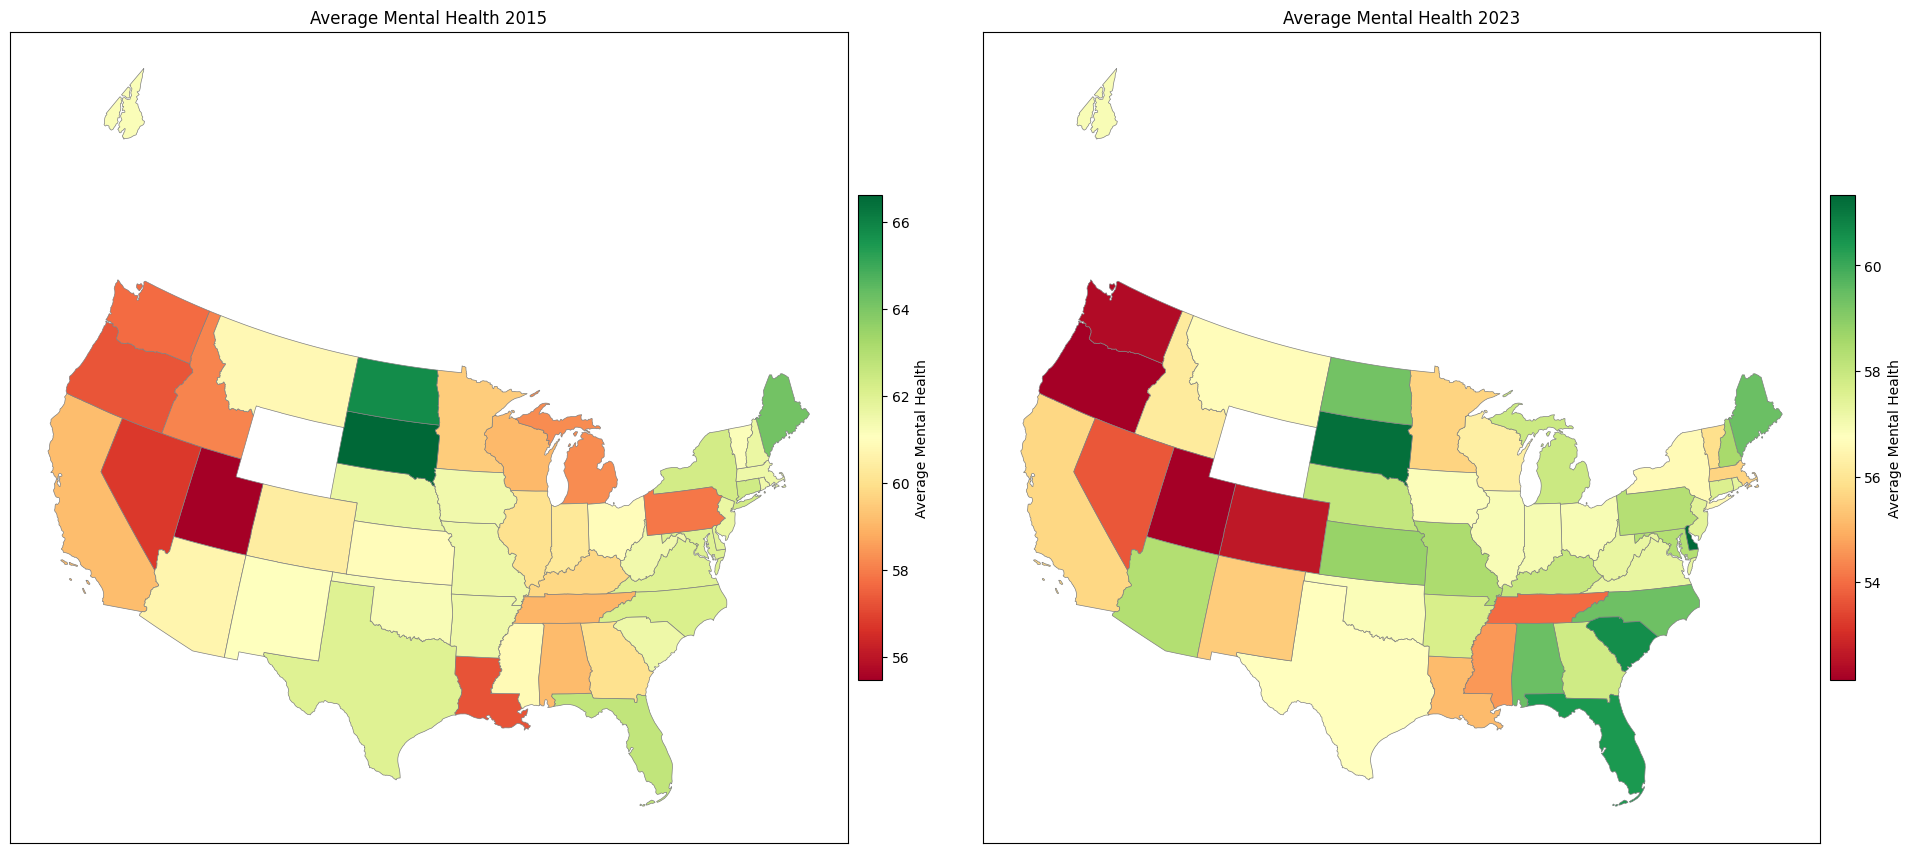

In [53]:
import matplotlib.pyplot as plt

gdfs = [merged_data_2015, merged_data_2023]
titles = ["2015", "2023"]

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for ax, gdf, title in zip(axes, gdfs, titles):
    gdf.plot(
        ax=ax,
        column='AVG_MENTHLTH',
        cmap='RdYlGn',   # red = low, green = high
        edgecolor='grey',
        linewidth=0.5,
        legend=True,
        legend_kwds={
            "fmt": "{:,.0f}",
            "orientation": "vertical",
            "shrink": 0.5,
            "pad": 0.01,
            "label": "Average Mental Health"
        }
    )
    ax.set_title(f"Average Mental Health {title}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


In [1]:
# https://www.irs.gov/statistics/soi-tax-stats-migration-data
# Florida 2021-22

In [2]:
# Working on origin counties

In [3]:
import pandas as pd

In [4]:
fl_inflow_origin = pd.read_excel("2122fl.xlsx", sheet_name="County Inflow", usecols="C:F", skiprows=5)
fl_inflow_origin.columns = ["state_code", "county_code", "state", "county_name"]

fl_inflow_counts = pd.read_excel("2122fl.xlsx", sheet_name="County Inflow", usecols="G:I", skiprows=5)
fl_inflow_counts.columns = ["number_of_returns", "number_of_individuals", "AGI"]



In [5]:
fl_inflow = pd.concat([fl_inflow_origin, fl_inflow_counts], axis=1)
fl_inflow.dropna(inplace= True)

In [6]:
fl_inflow

,state_code,county_code,state,county_name,number_of_returns,number_of_individuals,AGI
0,97.0,0.0,FL,Alachua County Total Migration-US,9071,14706,617922
1,97.0,1.0,FL,Alachua County Total Migration-Same State,5209,8328,291691
2,97.0,3.0,FL,Alachua County Total Migration-Different State,3862,6378,326230
3,98.0,0.0,FL,Alachua County Total Migration-Foreign,29,69,1645
4,12.0,1.0,FL,Alachua County Non-migrants,91857,171600,7839527
...,...,...,...,...,...,...,...
6269,59.0,1.0,DS,Other flows - Northeast,23,39,1411
6270,59.0,3.0,DS,Other flows - Midwest,38,71,1746
6271,59.0,5.0,DS,Other flows - South,168,354,7725
6272,59.0,7.0,DS,Other flows - West,42,86,2593


In [7]:
# within florida, so will remove that has state other than fl and then see top 20 number of individuals

In [8]:
fl_2_fl_inflow = fl_inflow[fl_inflow["state"] == "FL"]

In [9]:
top20_counties = (
    fl_2_fl_inflow[
        ~fl_2_fl_inflow["county_name"].str.contains(
            "Non-migrants|Total Migration-US and Foreign|Total Migration-Same State|Total Migration-Different State|Total Migration-Foreign",
            case=False,
            na=False
        )
    ]
    .sort_values(by="number_of_individuals", ascending=False)
    .head(20)[["county_name", "number_of_individuals"]]
)


In [10]:
print(top20_counties)

                                 county_name number_of_individuals
3751        Orange County Total Migration-US                 88755
433        Broward County Total Migration-US                 87547
1867  Hillsborough County Total Migration-US                 86371
4187    Palm Beach County Total Migration-US                 70850
3292    Miami-Dade County Total Migration-US                 70311
4936          Polk County Total Migration-US                 60301
1173         Duval County Total Migration-US                 55546
2482           Lee County Total Migration-US                 53757
4443         Pasco County Total Migration-US                 52596
4638      Pinellas County Total Migration-US                 51610
4040       Osceola County Total Migration-US                 40558
207        Brevard County Total Migration-US                 37471
6008       Volusia County Total Migration-US                 36830
5503      Sarasota County Total Migration-US                 3

In [72]:
############################### GENTRIFICATION ON LA ##################################

In [1]:
import pandas as pd
import geopandas as gpd

In [2]:
# we aready have shape file of LA from losangeles.gpkg
# la_shp = gpd.read_file("la_shapefile/tl_2023_06037_faces.shp")
# la_shp
# print(la_shp.columns)
# la_shp.plot()

In [3]:
gdf = gpd.read_file("losangeles.gpkg")

<Axes: >

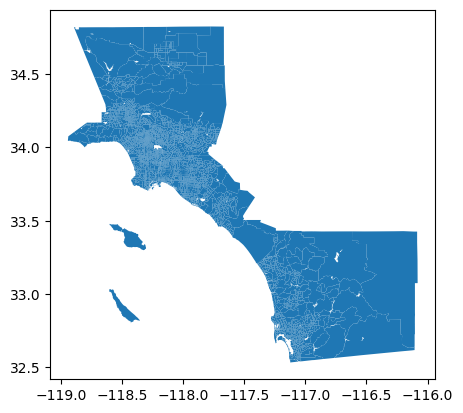

In [4]:
gdf.plot()

In [5]:
kaggle_data = pd.read_csv('census_tracts.csv')
cdc_data = pd.read_csv('500_cities_data.csv')

In [6]:
# This data isnt on LA
kaggle_data['city'].value_counts()

city
New York City    4700
Oakland           980
Washington        967
Atlanta           951
Baltimore         683
Name: count, dtype: int64

In [7]:
# kaggle_data['metro_area'].value_counts()

In [8]:
# Filter rows for Los Angeles from 500 cities and places data
la_df = cdc_data[cdc_data["CountyName"].str.contains("Los Angeles", case=False, na=False)].copy()

In [9]:
la_df["TractFIPS"] = la_df["TractFIPS"].astype(str)
gdf["GEOID"] = gdf["GEOID"].astype(str)
gdf["GEOID"] = gdf["GEOID"].str.replace(".0", "", regex=False)

# Perform a LEFT JOIN (all LA tracts kept, only matching gentrification data merged)
merged_df = la_df.merge(
    gdf,
    how="left",
    left_on="TractFIPS",
    right_on="GEOID"
)

print("Merged dataframe shape:", merged_df.shape)
print("Gentrification data available for:", merged_df['GEOID'].notna().sum(), "tracts")


Merged dataframe shape: (2474, 91)
Gentrification data available for: 2000 tracts


In [11]:
cols_to_keep = [
    "TractFIPS",
    "TotalPopulation",
    "TotalPop18plus",
    "MHLTH_CrudePrev",
    "Geolocation",
    "GEOID",
    "Typology",
    "geometry"
]
merged_gdf = gpd.GeoDataFrame(merged_df, geometry="geometry", crs=gdf.crs)

merged_gdf_subset = merged_gdf[cols_to_keep].copy()

In [12]:
merged_gdf_subset.columns

Index(['TractFIPS', 'TotalPopulation', 'TotalPop18plus', 'MHLTH_CrudePrev',
       'Geolocation', 'GEOID', 'Typology', 'geometry'],
      dtype='object')

In [13]:
merged_gdf_subset

,TractFIPS,TotalPopulation,TotalPop18plus,MHLTH_CrudePrev,Geolocation,GEOID,Typology,geometry
0,6037101110,4926,"4,083",16.1,POINT (-118.2929869 34.2594737),6037101110,Low-Income/Susceptible to Displacement,"MULTIPOLYGON (((-118.29792 34.26322, -118.2913..."
1,6037101122,3728,"3,063",15.0,POINT (-118.2901465 34.2677213),6037101122,Stable/Advanced Exclusive,"MULTIPOLYGON (((-118.29697 34.27881, -118.2899..."
2,6037101220,3344,"2,799",18.2,POINT (-118.2816328 34.2516083),6037101220,Low-Income/Susceptible to Displacement,"MULTIPOLYGON (((-118.28592 34.25590, -118.2849..."
3,6037101221,3444,"2,754",19.6,POINT (-118.2925767 34.254329),NaN,NaN,None
4,6037101222,2808,"2,209",20.9,POINT (-118.2885261 34.2513519),NaN,NaN,None
...,...,...,...,...,...,...,...,...
2469,6037980031,1748,"1,729",16.3,POINT (-118.2579674 33.7377955),6037980031,At Risk of Becoming Exclusive,"MULTIPOLYGON (((-118.29105 33.75378, -118.2905..."
2470,6037980033,89,69,25.8,POINT (-118.2203101 33.7443155),6037980033,Unavailable or Unreliable Data,"MULTIPOLYGON (((-118.24533 33.76374, -118.2454..."
2471,6037980034,110,87,17.8,POINT (-118.0397946 33.8977271),NaN,NaN,None
2472,6037980035,623,490,17.2,POINT (-117.9354578 34.0105697),NaN,NaN,None


<Axes: >

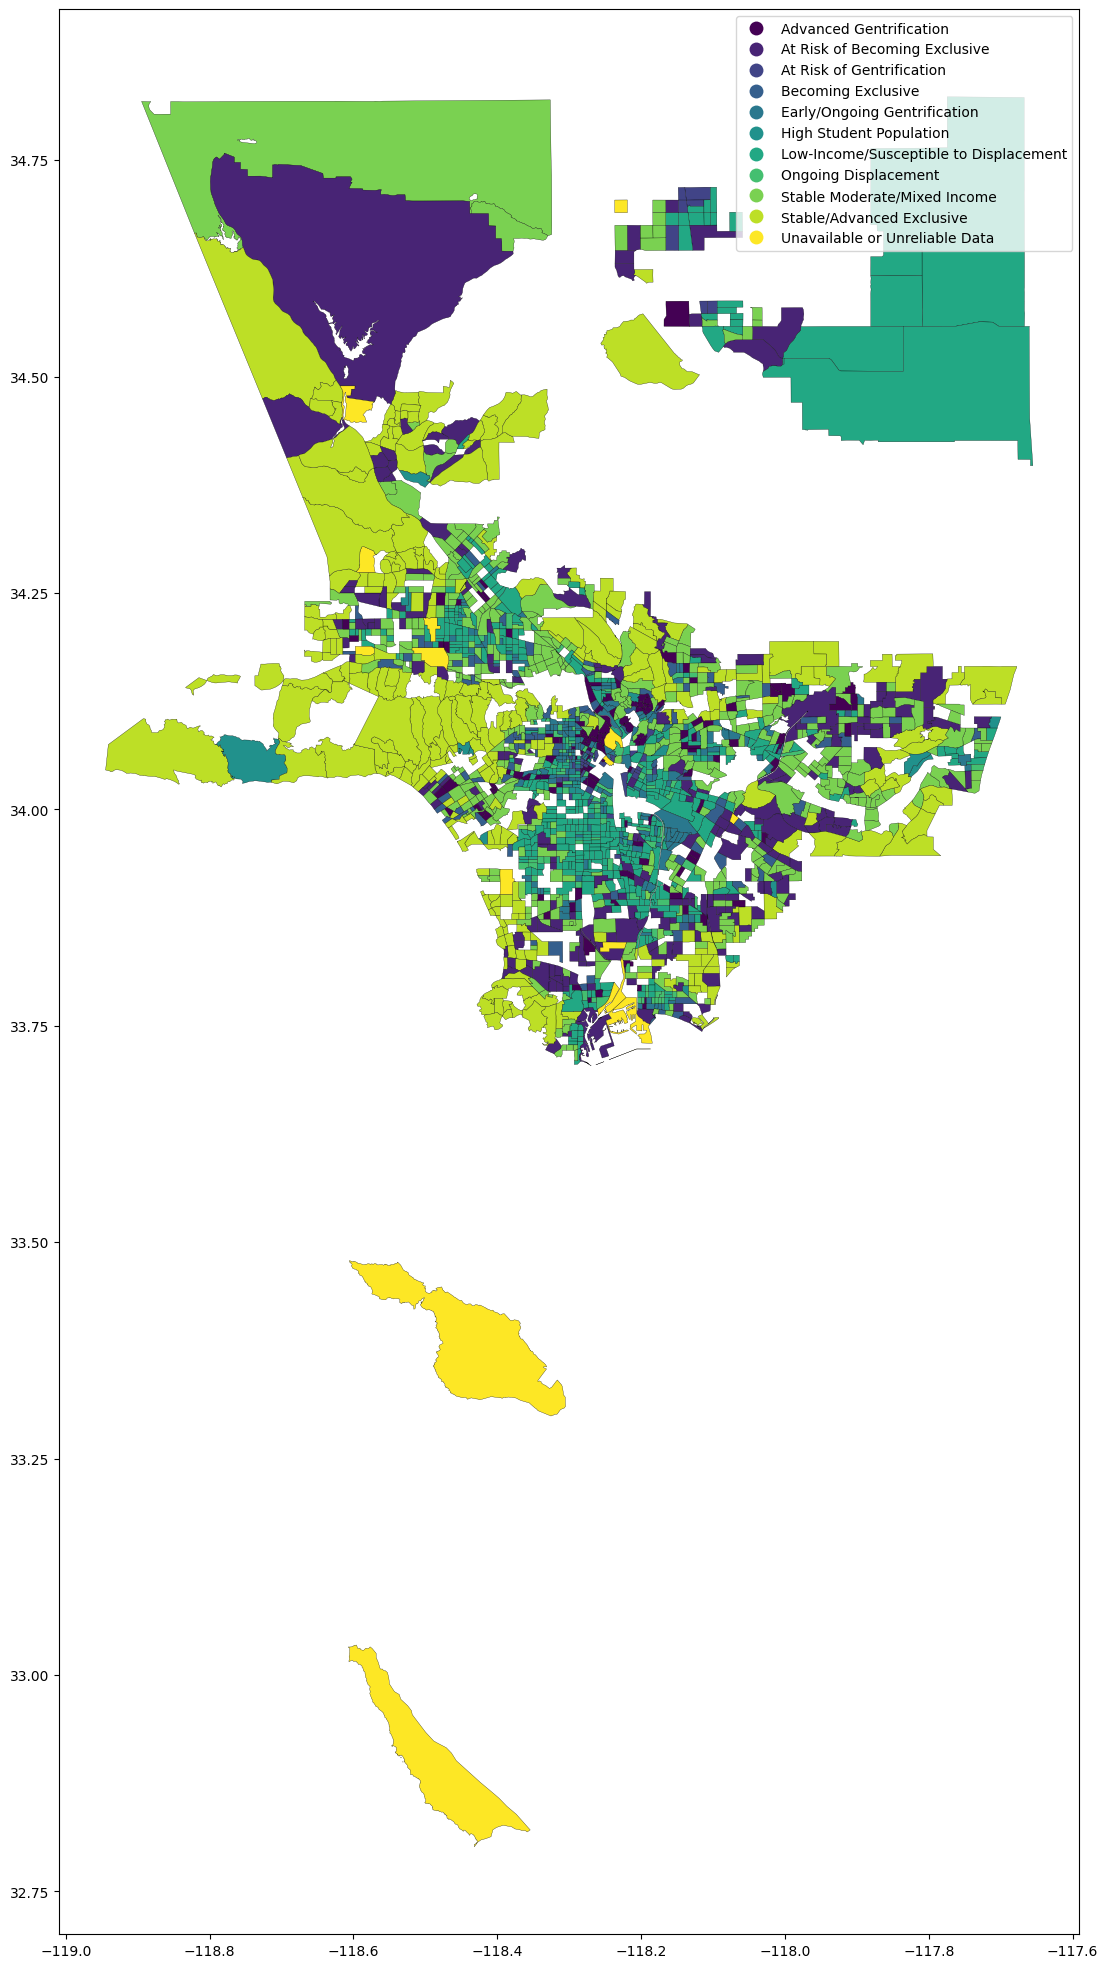

In [19]:
# Model-based estimate for crude prevalence of frequent mental distress among adults, 2022
    
merged_gdf_subset.plot(
    column="Typology",
    legend=True,
    figsize=(30, 25),
    cmap="viridis",
    edgecolor="black",
    linewidth=0.2
)

<Axes: >

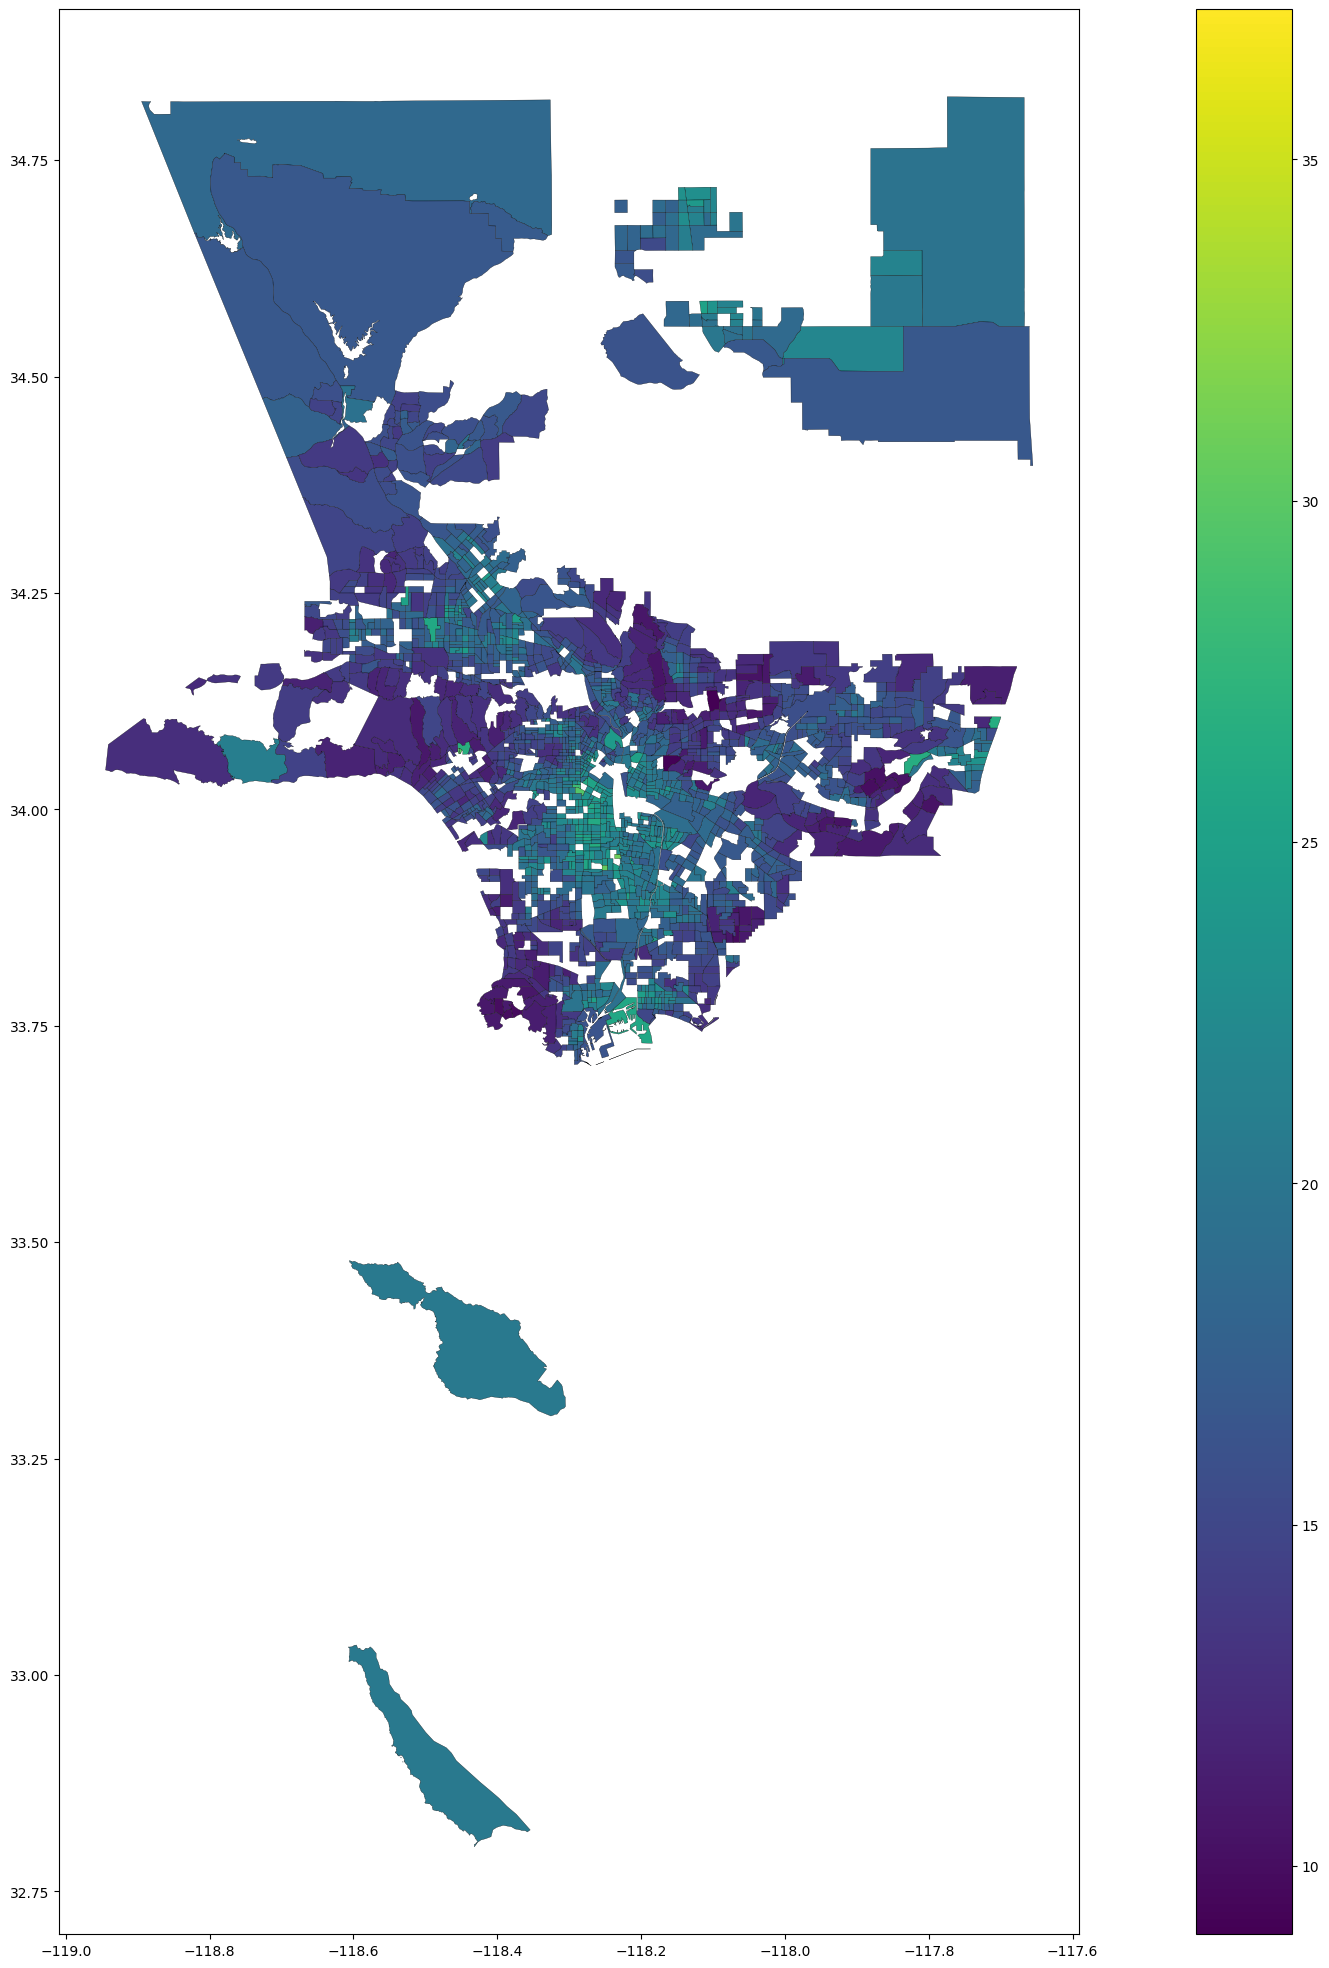

In [14]:
# Model-based estimate for crude prevalence of frequent mental distress among adults, 2022
    
merged_gdf_subset.plot(
    column="MHLTH_CrudePrev",
    legend=True,
    figsize=(30, 25),
    cmap="viridis",
    edgecolor="black",
    linewidth=0.2
)

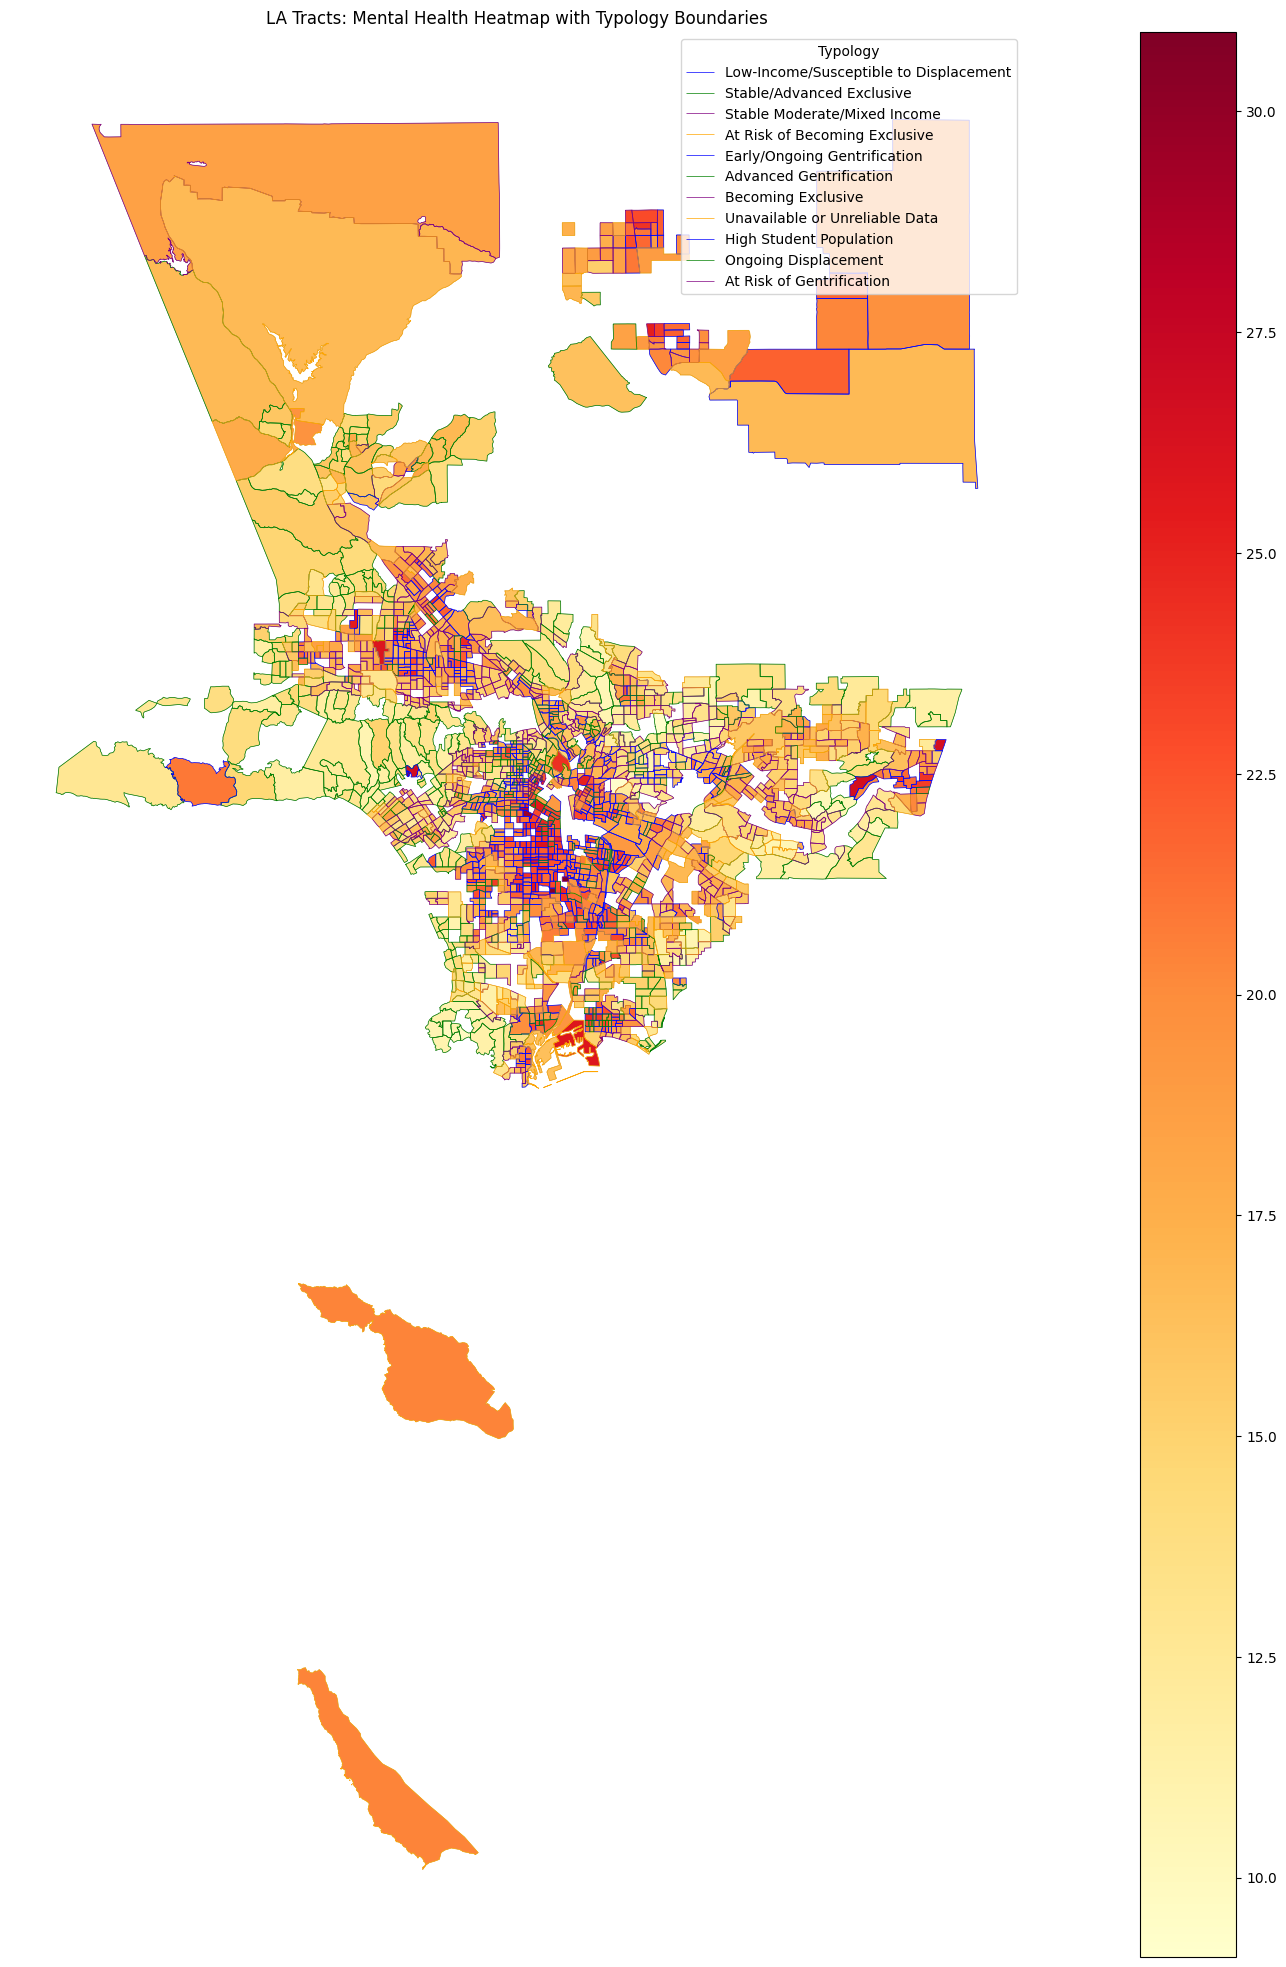

In [ ]:
import matplotlib.pyplot as plt

gdf_plot = merged_gdf_subset.copy()
gdf_plot = gpd.GeoDataFrame(gdf_plot, geometry="geometry")
gdf_plot = gdf_plot[gdf_plot.is_valid]

fig, ax = plt.subplots(1, 1, figsize=(30, 25))
# Plot heatmap of mental health prevalence
gdf_plot.plot(
    column="MHLTH_CrudePrev",
    cmap="YlOrRd",
    legend=True,
    ax=ax,
    edgecolor="grey",
    linewidth=0.2
)

# Overlay typology boundaries
typology_categories = gdf_plot["Typology"].unique()
colors = ["blue", "green", "purple", "orange"]

for i, cat in enumerate(typology_categories):
    gdf_plot[gdf_plot["Typology"] == cat].boundary.plot(
        ax=ax,
        edgecolor=colors[i % len(colors)],
        linewidth=0.5,
        label=cat
    )

ax.legend(title="Typology")
ax.set_axis_off()
plt.title("LA Tracts: Mental Health Heatmap with Typology Boundaries")
plt.show()
